# MAM Coagulation Verification Test

## Component Being Tested

Atmosphere, Modal Aerosol Model physics model, Coagulation

## Description

### Aerosol Modes

The Modal Aerosol Model (MAM) tracks aerosol particles via modes, so that a single distribution of particles over a range of diameters can be described by just three terms: a number concentration magnitude, a median particle diameter, and a standard deviation. The distribution, $n$ of particles of diameter $D_i$, for the $i$th mode, is given by

$$
n(\ln D_i) = \frac{N_{t,i}}{\sqrt{2\pi}\ln\sigma_{g,i}} \ \text{exp}\left[-\frac{1}{2}\frac{(\ln D_i -\ln D_{gn,i})^2}{\ln^2 \sigma_{g,i}}\right],
$$

where $N_{t,i}$ is the total number concentration, $\sigma_{g,i}$ is the standard deviation, and $D_{gn,i}$ is the median particle diameter. The subscript $g$ denotes a geometric quantity, $i$ denotes the $i$th mode, and **MAM tracks three modes**.  Note that this equation is a little different than a standard normal distribution, in that the random variable is the $\ln D_i$ rather than $D_i$ itself. Similarly, the effective mean is $\ln D_{gn,i}$ and the effective standard deviation is $\ln \sigma_{g,i}$.

As an example of a single aerosol mode, for a number concentration $N_{t,i} = 10^8$, a median diameter $D_{gn,i} = 0.2 \times 10^{-6}$m, and a standard deviation $\sigma_{g,i} = 1.8$m, the mode would look like this:

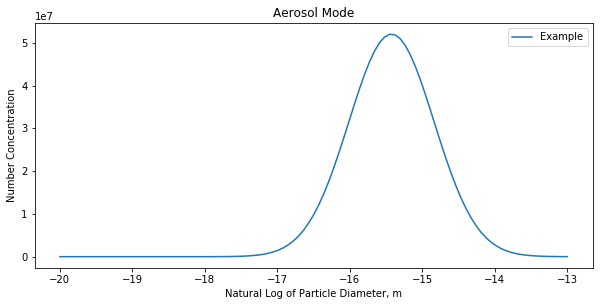

In [2]:
%matplotlib inline
import mam_util
mam_util.plot_single_mode(magnitude=1e8, median=0.2e-6, std_dev=1.8, label="Example")

The three modes tracked by MAM are referred to as the *Aitken* mode, the *Accumulation* mode and the *Primary Carbon* mode. Each mode has its own fixed standard deviation, but the number concentration magnitude and median particle diameters can vary over time. A composite of these modes at a typical distribution might look like this:

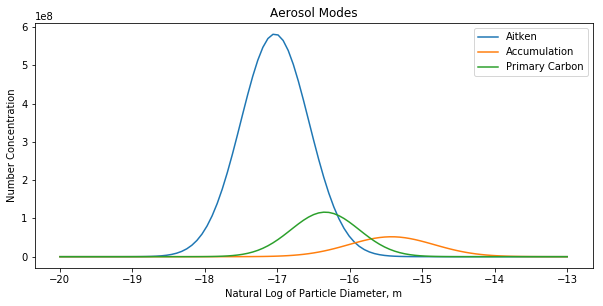

In [3]:
aitken = (1e9, 0.04e-6, 1.6, "Aitken")
accum  = (1e8, 0.20e-6, 1.8, "Accumulation")
pca    = (2e8, 0.08e-6, 1.6, "Primary Carbon")
mam_util.plot_three_modes(aitken, accum, pca)

Commonly in MAM, a normalized number distribution is tracked:

$$
n_{norm,i} = \frac{n(\ln D_i)}{N_{t,i}}.
$$

### Coagulation Rate Coefficients

Depending on the Knudsen number, different coagulation kernels apply.  The Knudsen number is a dimensionless number defined by

$$
\text{Kn}=\frac{2\lambda}{D},
$$

where $\lambda$ is the mean free path of the fluid surrounding a particle, and $D=\sqrt[3]{D_1^3+D_2^3}$ is the diameter of the particle.

$$
\beta_{nc}(D_{1},D_{2})=2 \pi\left[\frac{k_{\text{B}}TC_{C}}{3\pi\mu D_{1}} +
\frac{k_{\text{B}}TC_{C}}{3\pi\mu D_{2}}\right] (D_{1}+D_{2})
$$

$$
\tilde{\beta}_{fm}(D_{1},D_{2})=\left[\frac{3k_{\text{B}}T}{\rho_{p}}\right]^{1/2}
\left[D_{1}^{0.5}+2\frac{D_{2}}{D_{1}^{0.5}}+\frac{D_{2}^{2}}{D_{1}^{1.5}}+
\frac{D_{1}^2}{D_{2}^{1.5}}+2\frac{D_{1}}{D_{2}^{0.5}}+D_{2}^{0.5}\right]
$$

where $C_c$ is the slip correction factor, $\mu$ is the dynamic viscosity of air, $T$ is temperature (K), and $k_B$ is the Boltzmann constant.  $\beta_{nc}(D_1,D_2)$ applies in the near continuum regime $(\text{Kn}\le1)$, and $\beta_{fm}(D_1,D_2)$ applies in the free-molecular regime $(\text{Kn}>10)$.  For each of these, coagulation rate coefficients for intramodal and intermodal coagulation are calculated from

$$
B_{0,i,i} = \left[\frac{1}{2}\int_0^{\infty}n_{\text{norm},i} \text{d}(D_{1})
\int_0^{\infty}\beta(D_1,D_2) n_{\text{norm},i} \text{d}(D_{2})\right]
$$

$$
\begin{equation}
B_{0,i,j} = \left[\int_0^{\infty}n_{\text{norm},i} \text{d}(D_{1})
\int_0^{\infty}\beta(D_1,D_2) n_{\text{norm},j} \text{d}(D_{2})\right]
\end{equation}
$$

$$
\begin{equation}
B_{3,i,j} = \left[\int_0^{\infty}D_{1}^{3} n_{\text{norm},i} \text{d}(D_{1})
\int_0^{\infty}\beta(D_1,D_2) n_{\text{norm},j} \text{d}(D_{2})\right]
\left[\frac{1}{D_{gn,i}^{3} \text{exp}\left[\frac{9}{2} \text{ln}^{2}\sigma_{gi}\right]}\right]
\end{equation}
$$

where subscripts of $0$ and $3$ correspond to zeroth and third moments.  Once $B_{k,nc}$ and $B_{k,fm}$ are both known, the final coagulation rate coefficient used by MAM is given by the harmonic mean:

$$
B_k=\frac{B_{k,fm}B_{k,nc}}{B_{k,fm}+B_{k,nc}}
$$

#### Fuchs Kernel

In the verification test, the MAM coagulation rate coefficient is compared to the coefficient found using the Fuchs kernel:

$$
\beta\left(D_{1},D_{2}\right) = \frac{2\pi(\textbf{D}_1+\textbf{D}_2)(D_{1}+D_{2})}
{\left(\frac{D_{1}+D_{2}}{D_{1}+D_{2}+2(g_1^2+g_2^2)^{1/2}}+
\frac{8(\textbf{D}_1+\textbf{D}_2)}{(\bar{c}_1^2+\bar{c}_2^2)^{1/2}(D_{1}+D_{2})}\right)},
$$

where

$$
\begin{eqnarray}
\bar{c}_{i}    &=& \left(\frac{8kT}{\pi m_{i}}\right)^{1/2}\quad\text{m}/\text{s} \\
\ell_{i}       &=& \frac{8\textbf{D}_{i}}{\pi \bar{c}_{i}}\quad\text{m} \\
g_{i}          &=& \frac{1}{3D_{i}\ell_{i}}\left[(D_{i}+\ell_{i})^{3} - (D_{i}^2+\ell_{i}^2)^{3/2}\right] - D_{pi}\quad\text{m} \\
\textbf{D}_{i} &=&\frac{kTC_{c_{i}}}{3\pi \mu {D}_{i}}\quad\text{m}^2/\text{s} \\
C_{c_{i}}      &=& 1+\frac{2\lambda}{D_{pi}}\left[1.257 + 0.4\text{exp}\left(-\frac{1.1D_{i}}{2\lambda}\right)\right]
\end{eqnarray}
$$

## Variable Definitions

$$
\begin{array}{ll}
    D_i               & \mbox{Particle diameter for mode $i$. The PDF random variable is $(\ln D_i)$ } \\
    D_{gn,i}          & \mbox{Mean particle diameter for mode $i$ } \\
    g                 & \mbox{A subscript denoting geometric quantities} \\
    i                 & \mbox{Mode number} \\
    N_{t,i}           & \mbox{Total number concentration} \\
    n                 & \mbox{The number distribution of particles of diameter $D_i$ } \\
    n_{\text{norm},i} & \mbox{The normailzed number distribution of particles of diameter $D_i$ } \\
    \sigma_{g,i}      & \mbox{Standard deviation for mode $i$ } \\
    C_{c_i}           & \mbox{slip correction factor for mode $i$} \\
    \mu               & \mbox{dynamic viscosity of air} \\
    T                 & \mbox{temperature (K)} \\
    k_\text{B}        & \mbox{Boltzmann constant} \\
    \rho_p            & \mbox{?}
\end{array}
$$

## Discussion

The "whats" and "whys" of specific verification test parameter choices should be discussed here. Figures can also be helpful, e.g.

In [9]:
from IPython.display import display, Image
#display(Image(filename='InitialHeightField.png'))

The **Description** should provide the mathematics behind the verification test. The **Discussion** should provide the necessary insight and specific details that would allow a competent researcher to reproduce those tests.

## Results

Here is the meat of the verification test. It *could* include building the test, running the test, or extracting data from a nightly test, possibly run on a different platform. Feel free to break this section down into sub-sections. This will probably be the most code-intensive part of the notebook (python, shell script, or other), although it is highly recommended to provide a high-level interface to the testing and analysis, to make it as easy to follow as possible.

In [ ]:
%matplotlib inline
# Etc., etc.